# Fine-tune a pretrained model

Dataset: https://huggingface.co/datasets/raquiba/Sarcasm_News_Headline

Model: https://huggingface.co/bert-base-uncased

In [1]:
# set GPU as device
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

## Prepare Dataset

In [17]:
from datasets import load_dataset



dataset = load_dataset("raquiba/Sarcasm_News_Headline")

print(type(dataset))

# slight refactor
def refactor_dataset(example):
    
    # delete the unnecessary 'article_link' field
    del example['article_link']

    # rename 'headline' field to 'text'
    example['text'] = example.pop('headline')

    # rename 'is_sarcastic' field to 'label'
    example['label'] = example.pop('is_sarcastic')

    return example

dataset = dataset.map(refactor_dataset)

example = dataset["train"][2]
print(example)

Repo card metadata block was not found. Setting CardData to empty.


<class 'datasets.dataset_dict.DatasetDict'>


Map: 100%|██████████| 26709/26709 [00:00<00:00, 29803.13 examples/s]

{'text': 'eat your veggies: 9 deliciously different recipes', 'label': 0}


## Preprocessing

In the preprocessing stage, I define the tokenizer as it applies to the dataset. I used the same tokenizer from the original AI model, for consistency.

In [18]:
# grab the same tokenizer used to pretrain the original dataset
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# create tokenizer function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

# apply tokenizer to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# prepare a collator with dynamic padding
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map: 100%|██████████| 26709/26709 [00:00<00:00, 57068.17 examples/s]
2023-11-21 15:19:30.514460: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 15:19:31.556805: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
small_train_dataset = tokenized_datasets["train"]
small_train_dataset = tokenized_datasets["test"]

<a id='trainer'></a>

## Evaluation method

In [21]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [22]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

## Model Training

here I will grab the pretrained bert-base-cased model to be fine-tuned. I am specifying that there are 2 labels for binary classification: 0 for negative, and 1 for positive.

In [23]:
from transformers import AutoModelForSequenceClassification


id2label = {0: "NOT_SARCASTIC", 1: "SARCASTIC"}
label2id = {"NOT_SARCASTIC": 0, "SARCASTIC": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased", 
    num_labels=2,
    id2label=id2label, 
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
from transformers import Trainer
import time
import math
from tqdm import tqdm

class CustomTrainer(Trainer):
    def _inner_training_loop (
        self,
        batch_size = None, 
        args = None, 
        resume_from_checkpoint = None, 
        trial = None,
        ignore_keys_for_eval = None
    ):
        
        number_of_epochs = args.num_train_epochs
        start = time.time()
        train_loss = []
        train_acc = []
        eval_acc = []

        criterion = torch.nn.CrossEntropyLoss().to(device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma = 0.9)

        train_dataloader = self.get_train_dataloader()
        eval_dataloader = self.get_eval_dataloader()

        max_steps = math.ceil(args.num_train_epochs * len(train_dataloader))
        for epoch in range(number_of_epochs):
            train_loss_per_epoch = 0
            train_acc_per_epoch = 0
            with tqdm(train_dataloader, unit =  "batch") as training_epoch:
                training_epoch.set_description(f"Training Epoch {epoch}")

                for step, inputs in enumerate(training_epoch):
                    inputs = inputs.to(device)
                    labels = inputs['labels']

                    # forward pass
                    self.optimizer.zero_grad()
                    output = model(**inputs)
                    logits = output.logits

                    # get the loss
                    loss = criterion(logits, labels)
                    train_loss_per_epoch += loss.item()

                    # calculate gradients
                    loss.backward()
                    # update weights
                    self.optimizer.step()
                    train_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()

                # adjust the learning rate
                self.scheduler.step()
                train_loss_per_epoch /= len(train_dataloader)
                train_acc_per_epoch /= (len(train_dataloader) * batch_size)

                # keep track of loss and acc for visualization purposes:
                train_loss.append(train_loss_per_epoch)
                train_acc.append(train_acc_per_epoch)

                eval_loss_per_epoch = 0
                eval_acc_per_epoch = 0

                with tqdm(eval_dataloader, unit = "batch") as eval_epoch:
                    eval_epoch.set_description(f"Evaluation Epoch {epoch}")

                    for step,inputs in enumerate(eval_dataloader):
                        inputs = inputs.to(device)
                        labels = inputs['labels']

                        # Forward pass
                        self.optimizer.zero_grad()
                        output = model(**inputs)
                        logits = output.logits

                        # get the loss
                        loss = criterion(logits, labels)
                        eval_loss_per_epoch += loss.item()

                        # Calculate accuracy
                        eval_acc_per_epoch += (logits.argmax(1) == labels).sum().item()

                eval_loss_per_epoch /= (len(eval_dataloader))
                eval_acc_per_epoch /= (len(eval_dataloader)* batch_size)

                # keep track of accuracy for vizualization:
                eval_acc.append(eval_acc_per_epoch)

                print(f'\ tTrain Loss: {train_loss_per_epoch:.3f} | Train Acc: {train_acc_per_epoch * 100:.2f}%')

                print(f'\ tEval Loss: {eval_loss_per_epoch:.3f} | Eval Acc: {eval_acc_per_epoch * 100:.2f}%')

            print(f'Time : {(time.time() - start) / 60:.3f} minutes')

        return train_loss, train_acc, eval_acc


Finally, I define the Hyperparameter to be used during training. 

In [28]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="test_trainer",
    num_train_epochs=1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

Now the trainer is ready to be used

In [29]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_train_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

loss, acc, val_acc = trainer.train()

Training Epoch 0:  69%|██████▉   | 2298/3339 [03:52<01:45,  9.91batch/s]

## Evaluation

In [23]:
print(loss)
print(acc)
print(val_acc)

[0.2442042804983824, 0.13853448400897436, 0.09651902729148487, 0.07586506617803694, 0.12154794050307743]
[0.9043087064972087, 0.9522805558854971, 0.9689096092172467, 0.9753385200142535, 0.9439957239577147]
[0.8738532110091743, 0.8784403669724771, 0.8509174311926605, 0.8486238532110092, 0.7878440366972477]


<function matplotlib.pyplot.show(close=None, block=None)>

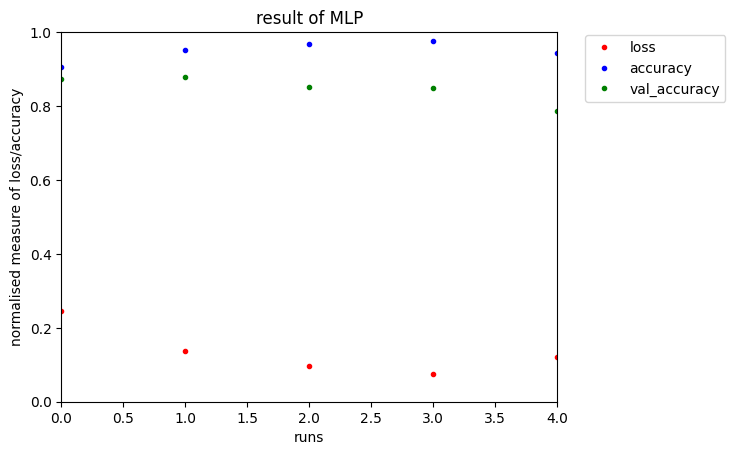

In [26]:
import matplotlib.pyplot as plt

plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=range(5)
plt.axis([0, max(x_len), 0, 1])
plt.title('result of MLP')
plt.plot(x_len, loss, 'r.',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

In [12]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)

In [28]:
# Save the model
torch.save(model.state_dict(), 'bert_model.pth')

# Save the tokenizer (if needed)
tokenizer.save_pretrained('bert_tokenizer')

('bert_tokenizer/tokenizer_config.json',
 'bert_tokenizer/special_tokens_map.json',
 'bert_tokenizer/vocab.txt',
 'bert_tokenizer/added_tokens.json',
 'bert_tokenizer/tokenizer.json')

In [49]:
from random import sample
import pandas as pd

testing_data = dataset["validation"]
len = testing_data.num_rows

text_list = []
prediction_list = []
label_list = []

for idx in range(len):
    text = testing_data[idx]["text"]
    label = testing_data[idx]["label"]
    prediction = label2id[classifier(text)[0]["label"]]

    if prediction != label:
        text_list.append(text)
        label_list.append(label)
        prediction_list.append(prediction)

# Create a DataFrame from the collected data
data = {
    "Text": text_list,
    "Prediction": prediction_list,
    "Label": label_list
}

df = pd.DataFrame(data)



/home/dog_hazard/miniconda3/envs/tf/lib/python3.9/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [54]:
print(df.shape)
print(len)

prediction_counts = df['Prediction'].value_counts()

# Print the counts
print("Fasle positives: ", prediction_counts[1])
try: 
    print("False negatives: ", prediction_counts[0])
except:
    print("no false negatives")

(185, 3)
872
Fasle positives:  41
False negatives:  144


In [52]:
false_positive = df[df['Prediction'] == 1]

false_negative = df[df['Prediction'] == 0]

print("False Positives:\n")
for text in false_positive['Text'].head(10): 
    print(text + "\n")

print("\nFalse Negatives:\n")
for text in false_negative['Text'].head(10):  
    print(text + "\n")


False Positives:

the title not only describes its main characters , but the lazy people behind the camera as well . 

for all its impressive craftsmanship , and despite an overbearing series of third-act crescendos , lily chou-chou never really builds up a head of emotional steam . 

this is a train wreck of an action film -- a stupefying attempt by the filmmakers to force-feed james bond into the mindless xxx mold and throw 40 years of cinematic history down the toilet in favor of bright flashes and loud bangs . 

you wo n't like roger , but you will quickly recognize him . 

his last movie was poetically romantic and full of indelible images , but his latest has nothing going for it . 

there is n't nearly enough fun here , despite the presence of some appealing ingredients . 

it seems to me the film is about the art of ripping people off without ever letting them consciously know you have done so 

the tale of tok ( andy lau ) , a sleek sociopath on the trail of o ( takashi sorima

# Citations

I used the following resources to complete this homework:

Dataset: https://huggingface.co/datasets/sst2/viewer/default/train

Model: https://huggingface.co/bert-base-uncased

Shirley's Presentation on September 19: https://docs.google.com/presentation/d/19AVdYw2ezOprQuBBumICEbfNpvJ-pVVURiOb7aQDjdo/edit#slide=id.g27c35a91bda_0_0

Shirley's jupyter notebook: https://colab.research.google.com/drive/1sMCEi6zXP8AQLoCrXf-QmiwoXB5v57wy

PyTorch programming tutorial from September 14: https://docs.google.com/presentation/d/1DNWnMJYswVhzo7hmI9mZLNhjPc8rNXsERM1bvFSE6Fo/edit#slide=id.g27d93a5fe38_0_92

PyTorch programming tutorial jupyter notebook: https://colab.research.google.com/drive/1Mely63oAnovTKoW82w1NuVJvs9HH5dqd?authuser=1

The homework assignment's custom trainer: https://dykang.github.io/classes/csci5541/F23/hw/CSCI_5541_F23_HW1.pdf

Hugging Face Tutorial: https://huggingface.co/docs/transformers/training

Original Paper: https://arxiv.org/pdf/1910.10683v4.pdf

## Chat GPT Prompts

write me a brief description of the NLP task binary sentiment classification

How can I get the model's predictions from the input data during the forward pass when fine-tuning a pre-trained model?

For loss calculation using CrossEntropyLoss, what's the correct way to compute the loss between the model's predictions (logits) and the labels?

Could you provide guidance on implementing an effective evaluation loop to assess the model's performance on the evaluation dataset, including both loss and accuracy calculations?

give an explanation of how binary cross-entropy is calculated, with an equation

list ways to improve the score of my NLP model, if it is over-fit

write a brief description of bert based uncased

write a brief description of sst2 dataset for binary sentiment classification